In [1]:
import os 
import random
import numpy as np

import torch 
from torch import nn 
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import random
import copy
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import cv2
import json

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
model_ident = "bidiretional_lstm_hrnet_nturgb"
unique_iden = "epoch10_emb2048xy"

main_dir = "D:\\FYP\\HAR-ZSL-XAI"
data_dir = os.path.join(main_dir,"data","sequence_data","random_50f")
epoch_vids = os.path.join(main_dir,"epoch_vids")
models_saves = os.path.join(main_dir,"model_saves")
embeddings_save = os.path.join(main_dir,"embedding_save")
test_vids = os.path.join(main_dir,"test_vids")
class_names = os.listdir(data_dir)
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 1-train_ratio - val_ratio
batch_size = 256

os.makedirs(epoch_vids,exist_ok=True)
os.makedirs(models_saves,exist_ok=True)
os.makedirs(embeddings_save,exist_ok=True)

In [4]:
config = {
    "n_epochs":100,
    "model_name":"BidirectionalLSTM",
    "model":{
        "seq_len":50,
        "input_size":12*2,
        "hidden_size":1024,
        "linear_filters":[128,256,512,1024],
        "embedding_size":2048,
        "num_layers":1,
        "bidirectional":True,
        "batch_size":batch_size,
        "dev":device
    }
}

In [5]:
def classname_id(class_name_list):
    id2classname = {k:v for k, v in zip(list(range(len(class_name_list))),class_name_list)}
    classname2id = {v:k for k, v in id2classname.items()}
    return id2classname, classname2id

In [6]:
class_names = [str(x) for x in range(120)]
class_names += os.listdir("../data/nipun_video_dataset/PAMAP2_K10_V1")

In [7]:
id2clsname, clsname2id = classname_id(class_names)

In [8]:
train_file_list = []
val_file_list = []
test_file_list = []

file_list = [os.path.join(data_dir,x) for x in os.listdir(data_dir)]

random.shuffle(file_list)
num_list = len(file_list)

train_range = [0,int(num_list*train_ratio)]
val_range = [int(num_list*train_ratio),int(num_list*(train_ratio+val_ratio))]
test_range = [int(num_list*(train_ratio+val_ratio)),num_list-1]

train_file_list += file_list[train_range[0]:train_range[1]]
val_file_list += file_list[val_range[0]:val_range[1]]
test_file_list += file_list[test_range[0]:test_range[1]]

In [9]:
len(train_file_list),len(val_file_list),len(test_file_list)

(18014, 2252, 2251)

In [10]:
train_file_list = train_file_list[:(len(train_file_list)//batch_size)*batch_size]
val_file_list = val_file_list[:(len(val_file_list)//batch_size)*batch_size]
test_file_list = test_file_list[:(len(test_file_list)//batch_size)*batch_size]

In [11]:
len(train_file_list),len(val_file_list),len(test_file_list)

(17920, 2048, 2048)

In [12]:
class SkeletonDataset(Dataset):
    def __init__(self, file_list,class2id, transform=None, 
                 target_transform=None,active_locations=[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],file_name=False, is_2d=False):
        self.file_list = file_list
        self.transform = transform
        self.class2id = class2id
        self.target_transform = target_transform
        self.active_locations = active_locations
        self.file_name = file_name
        self.is_2d = is_2d

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        a_file = np.load(self.file_list[idx])
        action_type = self.file_list[idx].strip().split(os.path.sep)[-1].split("_cls_")[0]
        coords, vid_size = a_file["coords"],a_file["video_size"]
        coords = coords[:,self.active_locations,:]

        if self.is_2d:
            coords = coords[...,0:2]

        shape = coords.shape

        coords = torch.from_numpy(coords).float()

        coords = torch.reshape(coords, (shape[0], shape[1]*shape[2]))
        label = torch.clone(coords)

        if self.transform:
            coords = self.transform(coords)
        if self.target_transform:
            label = self.target_transform(coords)

        if self.file_name:
            return coords, label, self.class2id[action_type],a_file["video_size"],self.file_list[idx]
        return coords, label, self.class2id[action_type],a_file["video_size"]

In [13]:
train_data = SkeletonDataset(train_file_list,clsname2id,is_2d=True)
val_data = SkeletonDataset(val_file_list,clsname2id,is_2d=True)
test_data = SkeletonDataset(test_file_list,clsname2id,is_2d=True)

In [14]:
train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=False)
val_dl = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [15]:
for x in train_dl:
    print(x[0].shape)
    break

torch.Size([256, 50, 24])


In [16]:

class BiLSTMEncoder(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size,linear_filters,embedding_size:int, num_layers = 1,bidirectional=True,dev=device):
        super(BiLSTMEncoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dev=dev
        self.num_layers = num_layers
        self.linear_filters = linear_filters
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.seq_len = seq_len

        # define LSTM layer
        self.layers = []

        # add linear layers 
        for __id,layer_out in enumerate(self.linear_filters):
            if __id == 0:
                self.layers.append(nn.Linear(self.input_size, layer_out))
            else:
                self.layers.append(nn.Linear(self.linear_filters[__id-1], layer_out))

        # add lstm layer
        self.lstm = nn.LSTM(input_size = layer_out, hidden_size = self.hidden_size,
                            num_layers = self.num_layers, bidirectional=self.bidirectional,
                            batch_first=True)
        
        self.net = nn.Sequential(*self.layers)

        #add embedding out
        if bidirectional:
            self.out_linear = nn.Linear(self.hidden_size*4, self.embedding_size)
        else:
            self.out_linear = nn.Linear(self.hidden_size*2, self.embedding_size)

        
    def forward(self, x_input):
        """
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence; hidden gives the hidden state and cell state for the last element in the sequence
        """
        
        x = self.net(x_input)
        lstm_out, self.hidden = self.lstm(x)
        hidden_transformed = torch.cat(self.hidden,0)
        hidden_transformed = torch.transpose(hidden_transformed,0,1)
        hidden_transformed = torch.flatten(hidden_transformed,start_dim=1)
        
        hidden_transformed = self.out_linear(hidden_transformed)
        
        return lstm_out, hidden_transformed

    
class BiLSTMDecoder(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size, linear_filters,embedding_size:int, num_layers = 1,bidirectional=True,dev=device):
        super(BiLSTMDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dev = dev
        self.num_layers = num_layers
        self.linear_filters = linear_filters[::-1]
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.seq_len = seq_len

        if bidirectional:
            self.input_linear = nn.Linear(self.embedding_size,4*self.hidden_size)
        else:
            self.input_linear = nn.Linear(self.embedding_size,2*self.hidden_size)

        # define LSTM layer
        self.layers = []
        # add lstm
        self.lstm = nn.LSTM(input_size = self.linear_filters[0], hidden_size = self.hidden_size,
                            num_layers = self.num_layers, bidirectional=True,
                            batch_first=bidirectional)

                        
        # add linear layers 
        if bidirectional:
            self.layers.append(nn.Linear(2*hidden_size,self.linear_filters[0]))
        else:
            self.layers.append(nn.Linear(hidden_size,self.linear_filters[0]))

        for __id,layer_in in enumerate(self.linear_filters):
            if __id == len(linear_filters)-1:
                self.layers.append(nn.Linear(layer_in,self.input_size))
            else:
                self.layers.append(nn.Linear(layer_in,self.linear_filters[__id+1]))

        self.net = nn.Sequential(*self.layers)

        
        

    def forward(self,encoder_hidden):
        """
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence; hidden gives the hidden state and cell state for the last element in the sequence
        """
        
        
        hidden_shape = encoder_hidden.shape
        encoder_hidden = self.input_linear(encoder_hidden)
        
        if self.bidirectional:
            hidden = encoder_hidden.view((-1,4,self.hidden_size))
            hidden = torch.transpose(hidden,1,0)
            h1,h2,c1,c2 = torch.unbind(hidden,0)
            h,c = torch.stack((h1,h2)),torch.stack((c1,c2))
            bs = h.size()[1]
        else:
            hidden = encoder_hidden.view((-1,2,self.hidden_size))
            hidden = torch.transpose(hidden,1,0)
            h,c = torch.unbind(hidden,0)
            bs = h.size()[1]
        
        dummy_input = torch.rand((bs,self.seq_len,self.hidden_size), requires_grad=True).to(self.dev)
        
        lstm_out, self.hidden = self.lstm(dummy_input,(h,c))
        x = self.net(lstm_out)
        
        return x

class BiLSTMEncDecModel(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size, linear_filters=[128,256,512],embedding_size:int=256, num_layers = 1,bidirectional=True,dev=device):
        super(BiLSTMEncDecModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dev = dev
        self.num_layers = num_layers
        self.linear_filters = linear_filters[::-1]
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.batch_size = batch_size
        self.seq_len = seq_len
        
        self.encoder = BiLSTMEncoder(seq_len, input_size, hidden_size, linear_filters,embedding_size, num_layers = 1,bidirectional=True, dev=self.dev)
        self.decoder = BiLSTMDecoder(seq_len, input_size, hidden_size, linear_filters,embedding_size, num_layers = 1,bidirectional=True, dev=self.dev)
        
    def forward(self,x):
        lstm_out,embedding = self.encoder(x)
        decoder_out = self.decoder(embedding)
        
        return decoder_out, embedding  
        

In [17]:
encoder = BiLSTMEncoder(
    seq_len=config["model"]["seq_len"],
    input_size=config["model"]["input_size"],
    hidden_size=config["model"]["hidden_size"],
    linear_filters=config["model"]["linear_filters"],
    embedding_size=config["model"]["embedding_size"],
    num_layers = config["model"]["num_layers"],
    bidirectional=config["model"]["bidirectional"],
    dev=config["model"]["dev"]).to(device)

decoder = BiLSTMDecoder(
    seq_len=config["model"]["seq_len"],
    input_size=config["model"]["input_size"],
    hidden_size=config["model"]["hidden_size"],
    linear_filters=config["model"]["linear_filters"],
    embedding_size=config["model"]["embedding_size"],
    num_layers = config["model"]["num_layers"],
    bidirectional=config["model"]["bidirectional"],
    dev=config["model"]["dev"]).to(device)

bilstm_model = BiLSTMEncDecModel(
    seq_len=config["model"]["seq_len"],
    input_size=config["model"]["input_size"],
    hidden_size=config["model"]["hidden_size"],
    linear_filters=config["model"]["linear_filters"],
    embedding_size=config["model"]["embedding_size"],
    num_layers = config["model"]["num_layers"],
    bidirectional=config["model"]["bidirectional"],
    dev=config["model"]["dev"])

In [18]:
bilstm_model.to(device)

BiLSTMEncDecModel(
  (encoder): BiLSTMEncoder(
    (lstm): LSTM(1024, 1024, batch_first=True, bidirectional=True)
    (net): Sequential(
      (0): Linear(in_features=24, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=512, bias=True)
      (3): Linear(in_features=512, out_features=1024, bias=True)
    )
    (out_linear): Linear(in_features=4096, out_features=2048, bias=True)
  )
  (decoder): BiLSTMDecoder(
    (input_linear): Linear(in_features=2048, out_features=4096, bias=True)
    (lstm): LSTM(1024, 1024, batch_first=True, bidirectional=True)
    (net): Sequential(
      (0): Linear(in_features=2048, out_features=1024, bias=True)
      (1): Linear(in_features=1024, out_features=512, bias=True)
      (2): Linear(in_features=512, out_features=256, bias=True)
      (3): Linear(in_features=256, out_features=128, bias=True)
      (4): Linear(in_features=128, out_features=24, bias=True)
    )
  )

In [19]:
lstm_out, embedding = encoder(torch.randn((32,50,24)).to(device))

In [20]:

embedding.shape

torch.Size([32, 2048])

In [21]:
decoder_out = decoder(embedding)

In [22]:
model_out,embedding = bilstm_model(torch.randn((32,50,24)).to(device))

In [23]:
model_out.shape

torch.Size([32, 50, 24])

In [24]:
model_out,embedding = bilstm_model(torch.randn((16,50,24)).to(device))

In [25]:
model_out.shape

torch.Size([16, 50, 24])

In [26]:
model_out,embedding = bilstm_model(torch.randn((5,50,24)).to(device))

In [27]:
model_out.shape

torch.Size([5, 50, 24])

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mapping_l = [
        [15, 13], [13, 11], [11, 5],
        [12, 14], [14, 16], [12, 6],
        [3, 1],[1, 2],[1, 0],[0, 2],[2,4],
        [9, 7], [7,5], [5, 6],
        [6, 8], [8, 10],
        ]
#mapping_l = []

from dataset.SkeletonData.visualize import *
from utils.train_utils import *

In [29]:
def train_model(model, train_dataset, val_dataset, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    std_loss = nn.L1Loss(reduction='mean').to(device)
    history = dict(train=[], val=[])
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
  
    for epoch in range(1, n_epochs + 1):
        model = model.train()

        train_losses = []
        for in_seq,tar_seq,action,vid_size in tqdm(train_dataset):
            optimizer.zero_grad()
            
            in_seq = in_seq.to(device)
            tar_seq = tar_seq.to(device)
            seq_pred,_  = model(in_seq)
            
            loss = std_loss(seq_pred, tar_seq)
            #loss += 0.5*contrastive_loss(embed,labels=sample_label.view(-1))
            #print(contrastive_loss(embed,labels=sample_label.view(-1)))

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for in_seq,tar_seq,action,vid_size in val_dataset:

                in_seq = in_seq.to(device)
                tar_seq = tar_seq.to(device)
                seq_pred,_  = model(in_seq)

                loss = std_loss(seq_pred, tar_seq)
                #loss += 0.5*contrastive_loss(embed,labels=sample_label.view(-1))
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

    model.load_state_dict(best_model_wts)
    save_model(model,model_ident,unique_iden,models_saves,config)
    return model.eval(), history

In [30]:
model, history = train_model(
  bilstm_model, 
  train_dl, 
  val_dl, 
  n_epochs=config["n_epochs"]
)va

100%|██████████| 70/70 [03:10<00:00,  2.72s/it]


Epoch 1: train loss 0.1002290246209928 val loss 0.07655702903866768


100%|██████████| 70/70 [04:53<00:00,  4.20s/it]


Epoch 2: train loss 0.07310237416199275 val loss 0.06679715868085623


100%|██████████| 70/70 [05:24<00:00,  4.64s/it]


Epoch 3: train loss 0.06942251303366252 val loss 0.0607987679541111


100%|██████████| 70/70 [05:38<00:00,  4.84s/it]


Epoch 4: train loss 0.05940787393067564 val loss 0.05968966567888856


100%|██████████| 70/70 [06:11<00:00,  5.31s/it]


Epoch 5: train loss 0.05967622165169035 val loss 0.06025484064593911


100%|██████████| 70/70 [04:19<00:00,  3.70s/it]


Epoch 6: train loss 0.059681352174707825 val loss 0.06026915181428194


100%|██████████| 70/70 [05:32<00:00,  4.75s/it]


Epoch 7: train loss 0.059588769025036264 val loss 0.05982249416410923


100%|██████████| 70/70 [05:57<00:00,  5.11s/it]


Epoch 8: train loss 0.05946650446525642 val loss 0.05944358604028821


100%|██████████| 70/70 [06:18<00:00,  5.40s/it]


Epoch 9: train loss 0.059342535798038755 val loss 0.05913534481078386


100%|██████████| 70/70 [06:32<00:00,  5.61s/it]


Epoch 10: train loss 0.0592517690466983 val loss 0.05892763566225767


100%|██████████| 70/70 [06:40<00:00,  5.72s/it]


Epoch 11: train loss 0.05917644293180534 val loss 0.058758280239999294


100%|██████████| 70/70 [06:43<00:00,  5.76s/it]


Epoch 12: train loss 0.05911294168659619 val loss 0.058669229969382286


100%|██████████| 70/70 [06:41<00:00,  5.74s/it]


Epoch 13: train loss 0.059055540497813905 val loss 0.058531034737825394


100%|██████████| 70/70 [06:40<00:00,  5.72s/it]


Epoch 14: train loss 0.058999467375023026 val loss 0.05843936884775758


100%|██████████| 70/70 [06:46<00:00,  5.81s/it]


Epoch 15: train loss 0.05895949501012053 val loss 0.05831098556518555


100%|██████████| 70/70 [06:46<00:00,  5.81s/it]


Epoch 16: train loss 0.05891777351498604 val loss 0.058263721875846386


100%|██████████| 70/70 [06:45<00:00,  5.79s/it]


Epoch 17: train loss 0.05888762569853238 val loss 0.058209306094795465


100%|██████████| 70/70 [06:45<00:00,  5.79s/it]


Epoch 18: train loss 0.058874745188014846 val loss 0.05816017324104905


100%|██████████| 70/70 [06:44<00:00,  5.78s/it]


Epoch 19: train loss 0.05885402022727898 val loss 0.05808193748816848


100%|██████████| 70/70 [06:43<00:00,  5.77s/it]


Epoch 20: train loss 0.05883213989436627 val loss 0.058048025239259005


100%|██████████| 70/70 [06:45<00:00,  5.79s/it]


Epoch 21: train loss 0.058810390798108916 val loss 0.057974140625447035


100%|██████████| 70/70 [06:44<00:00,  5.78s/it]


Epoch 22: train loss 0.05879827210945743 val loss 0.05791129218414426


100%|██████████| 70/70 [06:44<00:00,  5.78s/it]


Epoch 23: train loss 0.05877863924418177 val loss 0.057838624343276024


100%|██████████| 70/70 [06:45<00:00,  5.80s/it]


Epoch 24: train loss 0.05875259350453104 val loss 0.05777079751715064


100%|██████████| 70/70 [06:46<00:00,  5.81s/it]


Epoch 25: train loss 0.058743553715092794 val loss 0.057729354593902826


100%|██████████| 70/70 [06:51<00:00,  5.87s/it]


Epoch 26: train loss 0.05873504312975066 val loss 0.05771567765623331


100%|██████████| 70/70 [06:54<00:00,  5.92s/it]


Epoch 27: train loss 0.058727669290133885 val loss 0.05771634867414832


100%|██████████| 70/70 [06:54<00:00,  5.92s/it]


Epoch 28: train loss 0.0587316596614463 val loss 0.05777572840452194


100%|██████████| 70/70 [07:00<00:00,  6.01s/it]


Epoch 29: train loss 0.05873955509492329 val loss 0.05789140285924077


100%|██████████| 70/70 [06:51<00:00,  5.88s/it]


Epoch 30: train loss 0.05872175395488739 val loss 0.05796313565224409


100%|██████████| 70/70 [06:46<00:00,  5.81s/it]


Epoch 31: train loss 0.05867884749812739 val loss 0.057934500742703676


100%|██████████| 70/70 [06:45<00:00,  5.80s/it]


Epoch 32: train loss 0.05863710854734693 val loss 0.0579255037009716


100%|██████████| 70/70 [06:45<00:00,  5.79s/it]


Epoch 33: train loss 0.05861744348491941 val loss 0.057956538163125515


100%|██████████| 70/70 [06:46<00:00,  5.81s/it]


Epoch 34: train loss 0.058602213220936915 val loss 0.058017251547425985


100%|██████████| 70/70 [06:44<00:00,  5.78s/it]


Epoch 35: train loss 0.05859520451298782 val loss 0.058071041479706764


100%|██████████| 70/70 [06:45<00:00,  5.80s/it]


Epoch 36: train loss 0.05858746873480933 val loss 0.05805753916501999


100%|██████████| 70/70 [06:41<00:00,  5.74s/it]


Epoch 37: train loss 0.05858299913150924 val loss 0.05803774017840624


100%|██████████| 70/70 [06:39<00:00,  5.71s/it]


Epoch 38: train loss 0.058579986755337037 val loss 0.05802851961925626


100%|██████████| 70/70 [06:42<00:00,  5.74s/it]


Epoch 39: train loss 0.058591781982353756 val loss 0.058046812657266855


100%|██████████| 70/70 [06:43<00:00,  5.76s/it]


Epoch 40: train loss 0.05862610600888729 val loss 0.058059359434992075


100%|██████████| 70/70 [06:51<00:00,  5.88s/it]


Epoch 41: train loss 0.05865195638367108 val loss 0.058004912454634905


100%|██████████| 70/70 [05:55<00:00,  5.07s/it]


Epoch 42: train loss 0.058601209468075205 val loss 0.05813205149024725


100%|██████████| 70/70 [06:41<00:00,  5.74s/it]


Epoch 43: train loss 0.05862593198461192 val loss 0.05822373181581497


100%|██████████| 70/70 [06:45<00:00,  5.79s/it]


Epoch 44: train loss 0.058667584934404916 val loss 0.05799306137487292


100%|██████████| 70/70 [06:47<00:00,  5.82s/it]


Epoch 45: train loss 0.05867179908922741 val loss 0.058633220847696066


100%|██████████| 70/70 [06:44<00:00,  5.78s/it]


Epoch 46: train loss 0.05872681476175785 val loss 0.05840587383136153


100%|██████████| 70/70 [06:44<00:00,  5.77s/it]


Epoch 47: train loss 0.0585548604705504 val loss 0.05807790672406554


100%|██████████| 70/70 [06:49<00:00,  5.85s/it]


Epoch 48: train loss 0.058514017718178886 val loss 0.05799477268010378


100%|██████████| 70/70 [06:44<00:00,  5.78s/it]


Epoch 49: train loss 0.058503787006650654 val loss 0.05796406790614128


100%|██████████| 70/70 [06:42<00:00,  5.75s/it]


Epoch 50: train loss 0.058498584532311985 val loss 0.057946701534092426


100%|██████████| 70/70 [06:39<00:00,  5.71s/it]


Epoch 51: train loss 0.058496383790458954 val loss 0.057931953109800816


100%|██████████| 70/70 [06:40<00:00,  5.72s/it]


Epoch 52: train loss 0.05849352074520928 val loss 0.057918498292565346


100%|██████████| 70/70 [06:41<00:00,  5.73s/it]


Epoch 53: train loss 0.058491528353520804 val loss 0.057915544137358665


100%|██████████| 70/70 [06:33<00:00,  5.62s/it]


Epoch 54: train loss 0.05849055078412805 val loss 0.057908495888113976


100%|██████████| 70/70 [06:16<00:00,  5.38s/it]


Epoch 55: train loss 0.058489127776452474 val loss 0.057903796434402466


100%|██████████| 70/70 [05:39<00:00,  4.85s/it]


Epoch 56: train loss 0.05848908078457628 val loss 0.05790258478373289


100%|██████████| 70/70 [05:43<00:00,  4.91s/it]


Epoch 57: train loss 0.05848834360284465 val loss 0.05789592303335667


100%|██████████| 70/70 [05:36<00:00,  4.81s/it]


Epoch 58: train loss 0.058487872566495624 val loss 0.0578951514326036


100%|██████████| 70/70 [05:25<00:00,  4.65s/it]


Epoch 59: train loss 0.05848819592169353 val loss 0.05789389042183757


100%|██████████| 70/70 [05:22<00:00,  4.61s/it]


Epoch 60: train loss 0.058488104918173384 val loss 0.057889030780643225


100%|██████████| 70/70 [05:20<00:00,  4.59s/it]


Epoch 61: train loss 0.058488481012838225 val loss 0.05789271742105484


100%|██████████| 70/70 [05:24<00:00,  4.63s/it]


Epoch 62: train loss 0.05848237579422338 val loss 0.05788473738357425


100%|██████████| 70/70 [05:17<00:00,  4.53s/it]


Epoch 63: train loss 0.058485677944762365 val loss 0.057891230564564466


100%|██████████| 70/70 [05:15<00:00,  4.51s/it]


Epoch 64: train loss 0.058484325877257756 val loss 0.05788912018761039


100%|██████████| 70/70 [05:20<00:00,  4.57s/it]


Epoch 65: train loss 0.058480803455625265 val loss 0.05789458891376853


100%|██████████| 70/70 [05:45<00:00,  4.93s/it]


Epoch 66: train loss 0.058479033676641326 val loss 0.05789566319435835


100%|██████████| 70/70 [05:19<00:00,  4.56s/it]


Epoch 67: train loss 0.058482797018119266 val loss 0.05788719793781638


100%|██████████| 70/70 [05:13<00:00,  4.48s/it]


Epoch 68: train loss 0.05847794972360134 val loss 0.05788686638697982


100%|██████████| 70/70 [05:32<00:00,  4.75s/it]


Epoch 69: train loss 0.05847902282008103 val loss 0.057889518328011036


100%|██████████| 70/70 [05:51<00:00,  5.02s/it]


Epoch 70: train loss 0.05847795605659485 val loss 0.0578854288905859


100%|██████████| 70/70 [06:08<00:00,  5.27s/it]


Epoch 71: train loss 0.0584780676556485 val loss 0.057905183639377356


100%|██████████| 70/70 [06:20<00:00,  5.44s/it]


Epoch 72: train loss 0.05848310669617993 val loss 0.05794090358540416


100%|██████████| 70/70 [06:19<00:00,  5.42s/it]


Epoch 73: train loss 0.05848896418298994 val loss 0.057900816667824984


100%|██████████| 70/70 [06:27<00:00,  5.53s/it]


Epoch 74: train loss 0.05848249404558114 val loss 0.05789416702464223


100%|██████████| 70/70 [06:30<00:00,  5.58s/it]


Epoch 75: train loss 0.058478777429887226 val loss 0.057892111130058765


100%|██████████| 70/70 [06:24<00:00,  5.50s/it]


Epoch 76: train loss 0.05847388623016221 val loss 0.057885884772986174


100%|██████████| 70/70 [06:24<00:00,  5.49s/it]


Epoch 77: train loss 0.058473344147205356 val loss 0.05791121907532215


100%|██████████| 70/70 [06:30<00:00,  5.57s/it]


Epoch 78: train loss 0.058478934317827226 val loss 0.057889715768396854


100%|██████████| 70/70 [06:32<00:00,  5.60s/it]


Epoch 79: train loss 0.05847242511808872 val loss 0.05790150351822376


100%|██████████| 70/70 [06:29<00:00,  5.57s/it]


Epoch 80: train loss 0.058479222123112 val loss 0.057879993226379156


100%|██████████| 70/70 [06:42<00:00,  5.74s/it]


Epoch 81: train loss 0.05846999873008047 val loss 0.057891981676220894


100%|██████████| 70/70 [06:45<00:00,  5.79s/it]


Epoch 82: train loss 0.0584677593516452 val loss 0.057883350644260645


100%|██████████| 70/70 [06:45<00:00,  5.79s/it]


Epoch 83: train loss 0.058466447996241705 val loss 0.05788093525916338


100%|██████████| 70/70 [06:46<00:00,  5.81s/it]


Epoch 84: train loss 0.058469116794211524 val loss 0.05788770178332925


100%|██████████| 70/70 [06:46<00:00,  5.81s/it]


Epoch 85: train loss 0.05846898332238197 val loss 0.05787764256820083


100%|██████████| 70/70 [06:47<00:00,  5.82s/it]


Epoch 86: train loss 0.05846103105161871 val loss 0.05786783620715141


100%|██████████| 70/70 [06:46<00:00,  5.80s/it]


Epoch 87: train loss 0.0584602238876479 val loss 0.057897011283785105


100%|██████████| 70/70 [06:46<00:00,  5.81s/it]


Epoch 88: train loss 0.058497178288442746 val loss 0.05803968803957105


100%|██████████| 70/70 [06:46<00:00,  5.81s/it]


Epoch 89: train loss 0.05850817752735955 val loss 0.0579683892428875


100%|██████████| 70/70 [06:46<00:00,  5.81s/it]


Epoch 90: train loss 0.05849112942814827 val loss 0.05788526497781277


100%|██████████| 70/70 [06:47<00:00,  5.82s/it]


Epoch 91: train loss 0.05846127596284662 val loss 0.05783440312370658


100%|██████████| 70/70 [06:47<00:00,  5.81s/it]


Epoch 92: train loss 0.05845369563571044 val loss 0.05784141272306442


100%|██████████| 70/70 [06:46<00:00,  5.81s/it]


Epoch 93: train loss 0.058453185430594856 val loss 0.05784438690170646


100%|██████████| 70/70 [06:46<00:00,  5.81s/it]


Epoch 94: train loss 0.05845224229352815 val loss 0.057843738701194525


100%|██████████| 70/70 [06:46<00:00,  5.80s/it]


Epoch 95: train loss 0.058451337473733087 val loss 0.05783885391429067


100%|██████████| 70/70 [06:46<00:00,  5.81s/it]


Epoch 96: train loss 0.05844959526189736 val loss 0.057834175415337086


100%|██████████| 70/70 [06:47<00:00,  5.82s/it]


Epoch 97: train loss 0.058449448219367435 val loss 0.05783312767744064


100%|██████████| 70/70 [06:46<00:00,  5.81s/it]


Epoch 98: train loss 0.05845000105244773 val loss 0.05783222150057554


100%|██████████| 70/70 [06:47<00:00,  5.82s/it]


Epoch 99: train loss 0.05844776252550738 val loss 0.0578280184417963


100%|██████████| 70/70 [06:46<00:00,  5.81s/it]


Epoch 100: train loss 0.0584470550928797 val loss 0.057830626145005226


In [31]:
save_history(history,model_ident,unique_iden,models_saves,config)

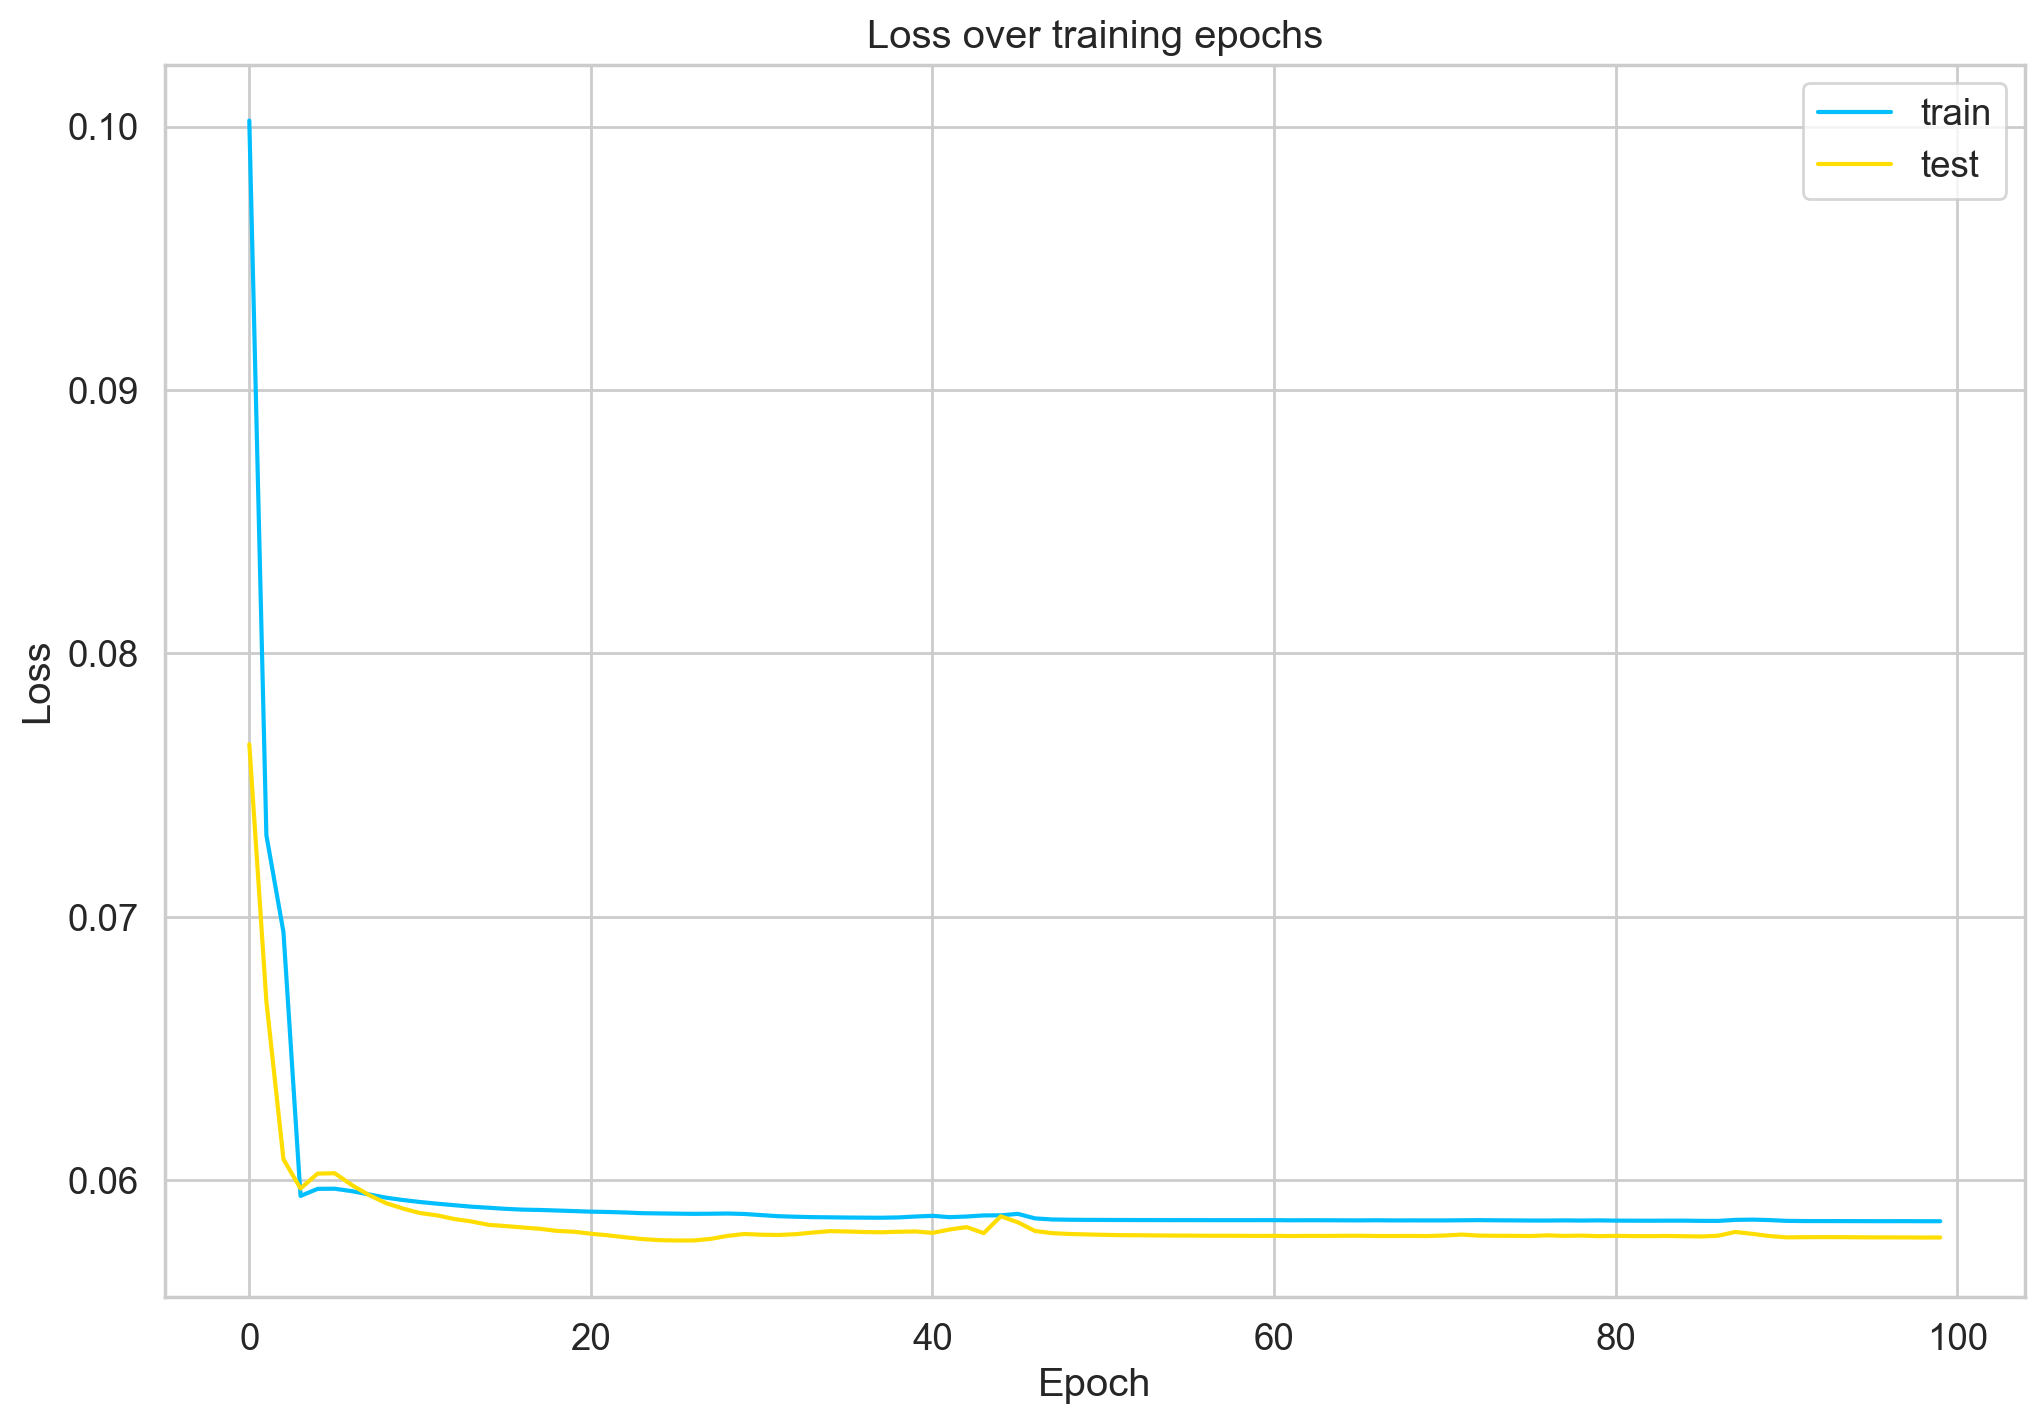

In [32]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [33]:
embedding_list = {}
output_list = {}
with torch.no_grad():
    for in_seq,tar_seq,action,vid_size in tqdm(test_dl):
        in_seq = in_seq.to(device)
        tar_seq = tar_seq.to(device)
        seq_pred,embedding  = model(in_seq)

        for seq,emb,action in zip(seq_pred.unbind(0),embedding.unbind(0),action.unbind(0)):
                try:
                    if len(embedding_list[int(action)])<=50:
                        embedding_list[int(action)].append(emb)
                        output_list[int(action)].append(seq)
                except KeyError:
                    embedding_list[int(action)] = [emb]
                    output_list[int(action)] = [emb]

        
            
        
        #embedding_list[]

100%|██████████| 8/8 [00:44<00:00,  5.53s/it]


In [34]:
import random

def draw_heatmaps(arr_list,nrows=2,ncols=2):
    ran_list = random.sample(arr_list,ncols*nrows)
    fig, ax = plt.subplots(nrows=nrows,ncols=ncols, sharex=True)
    for i in range(nrows):
        for j in range(ncols):
            #print(i*ncols+j,len(ran_list))
            ax[i,j].imshow(ran_list[i*ncols+j].detach().cpu().numpy()[np.newaxis,:], cmap="plasma", aspect="auto")

    plt.tight_layout()
    plt.show()

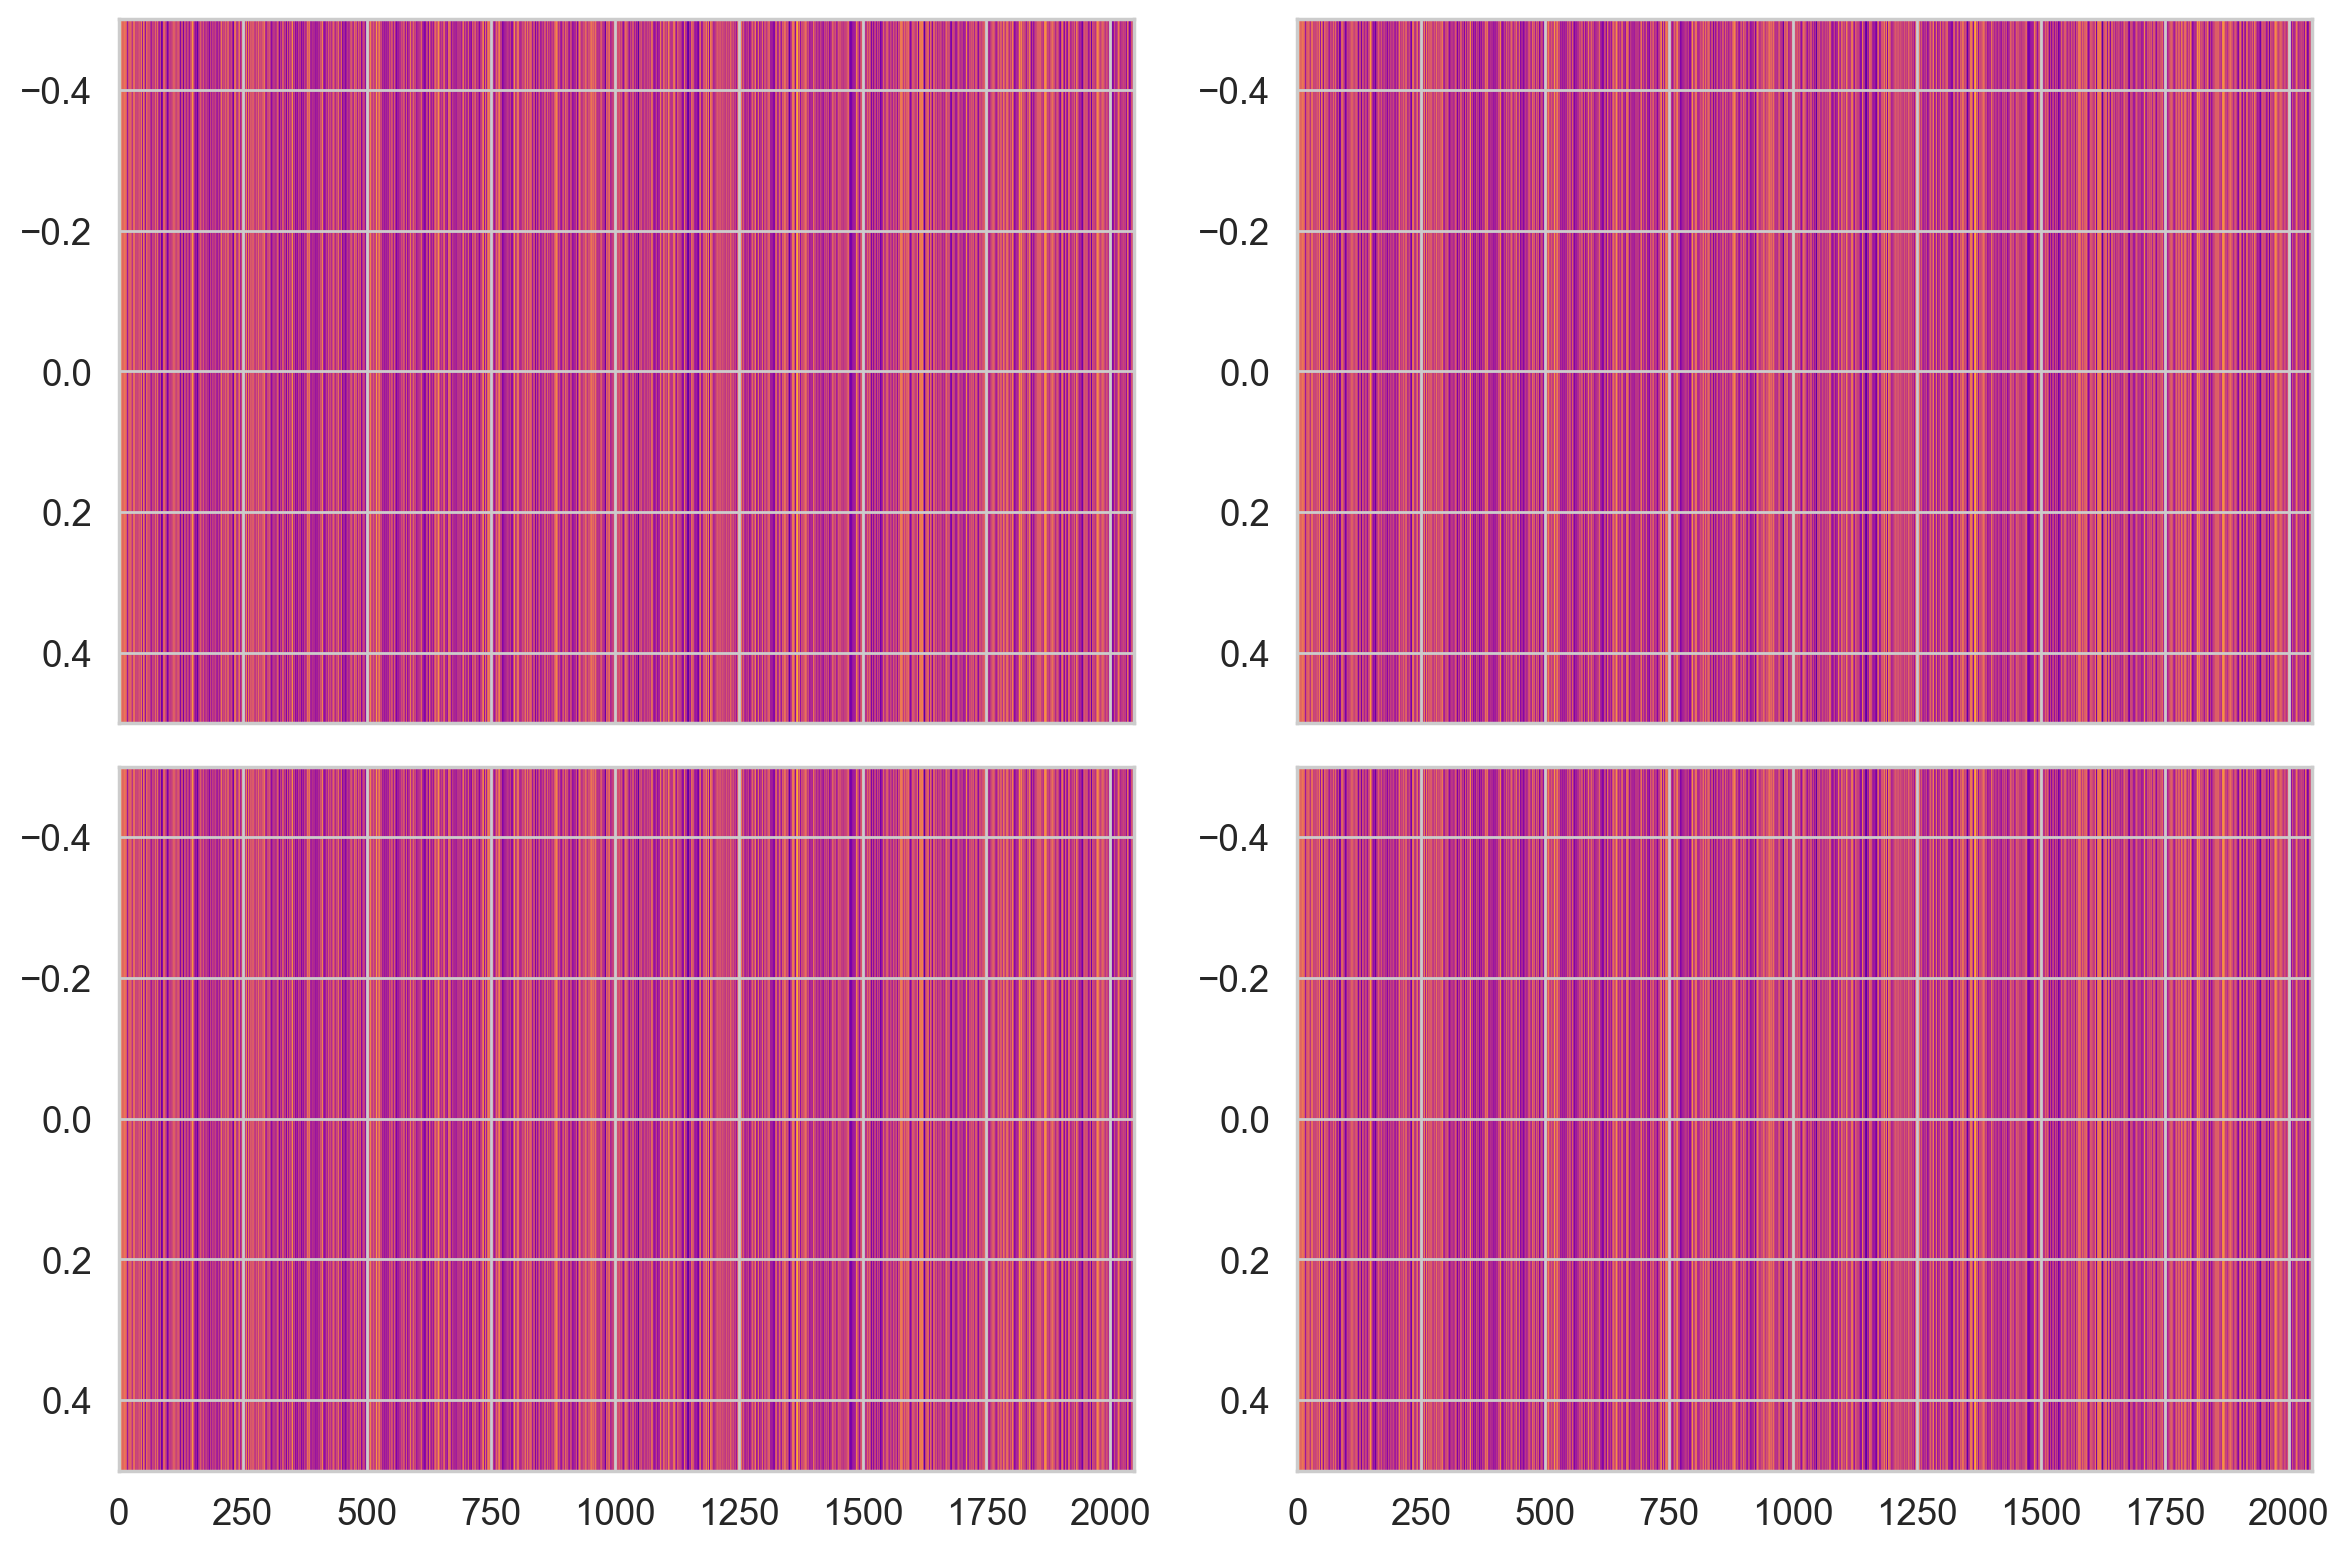

In [35]:
draw_heatmaps(embedding_list[11])

In [36]:
draw_heatmaps(embedding_list[22])

ValueError: Sample larger than population or is negative

In [ ]:
draw_heatmaps(embedding_list[16])

In [ ]:
def gen_video_from_embeddings(embedding,model,save_file):
    seq_out = model.decoder(embedding.repeat(batch_size,1,1))
    gen_video(seq_out[0].detach().numpy(), save_file, 400, 400,mapping_list=mapping_l)

In [ ]:
with torch.no_grad():
    for __id,(in_seq,tar_seq,action,vid_size) in tqdm(enumerate(test_dl)):
        in_seq = in_seq.to(device)
        tar_seq = tar_seq.to(device)
        seq_pred,embedding  = model(in_seq)

        for __id,(input_vid,output_vid,action) in enumerate(zip(in_seq.unbind(0),seq_pred.unbind(0),action.unbind(0))):
            os.makedirs(f"{test_vids}/{int(action)}",exist_ok=True)

            

        
            
        
        #embedding_list[]

In [ ]:
gen_video_from_embeddings(embedding_list[1][10],model,"embed_video.mp4")

In [ ]:
test_emb = 0.5*embedding_list[19][0]+0.5*embedding_list[16][0]
gen_video_from_embeddings(test_emb,model,"test_embed_video.mp4")